<a href="https://colab.research.google.com/github/dustin-kang/Proj2_SoccerPlayer-Machine-Learning/blob/main/Report/7_Hyperparameter_Tuning_Regressor_except_overall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter_Tuning_Regressor

파라미터 최적화를 통해 더 좋은 성능을 내기 위해 모델을 조정한다.


<aside>

### **💡 4) 머신러닝 방식 적용 및 교차검증**

데이터의 탐색과 전처리 작업이 끝났다면 **모델링을 통해 베이스라인과의 성능 비교**를 해봅니다.

- Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)
- 평가지표를 계산 후 베이스라인과 비교해보세요.
- 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.
- 모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.
    - Hyperparameter tuning, etc.
- 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.
- 최종 모델의 test 점수를 보고하세요.

### **태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.**

1. 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
2. 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
3. 최종 모델에 관해 설명하세요.
</aside>

In [25]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 컬럼 출력하기
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

df = pd.read_csv('../data/reg_data.csv')

df.drop(columns=['position','overall'], axis=1, inplace=True)


## 1. Train, Test, Split

In [26]:
df['value_eur'][df['value_eur'].isna()] = df['value_eur'].median()

In [27]:
from sklearn.model_selection import train_test_split 

target = 'value_eur'
train, test = train_test_split(df, random_state=2, train_size=.75)
train, val = train_test_split(train, random_state=2, train_size=.75)
train.shape, val.shape, test.shape

((10656, 104), (3552, 104), (4736, 104))

In [28]:
features = train.columns.drop(target)

# X (Features)
X_train = train[features] 
X_test = test[features]
y_train = train[target]

# y (Target)
X_val = val[features]
y_val = val[target] 
y_test = test[target]

## pre-OneHot Encoding

In [29]:
# preprocessing

from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Classifier Model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error

# Model Selection, Parameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [30]:
pipe = make_pipeline(
                      OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                      SimpleImputer(missing_values=np.nan, strategy='mean'),
                      MinMaxScaler(),
)

X_train_transformed = pipe.fit_transform(X_train)
X_val_transformed = pipe.transform(X_val)
X_test_transformed = pipe.transform(X_test)

## GridSearchCV

- GridSearch : 모델링시 필요한 하이퍼파라미터를 설정할 때 가장 최적의 파리미터값을 찾아주는 방법 
- 추가적으로 교차검증(Cross Validation)까지 수행

### 1

In [32]:
# Modeling

rf = RandomForestRegressor()
# param = {'n_estimators' : range(50, 600, 10)}
param = {'n_estimators' : [340, 350, 360, 370]}

reg = GridSearchCV(rf,
                   param_grid = param,
                   n_jobs=-1,
                   #cv=5, # 하나의 파라미터 쌍으로 모델링할 때, train, test 교차검증을 5번 실행.
                   scoring="neg_mean_squared_error",
                   refit=True, # GridSearch 진행 후 최고의 파라미터로 학습.
                   verbose=2)

# 학습 수행
reg.fit(X_train_transformed, y_train)

In [ ]:
y_pred = reg.predict(X_val_transformed)
best_score = -reg.best_score_
best_score ** 0.5

632126.2787955456

In [ ]:
r2_score(y_val, y_pred)

0.9749995617830206

In [ ]:
y_pred = reg.predict(X_train_transformed)
r2_score(y_train, y_pred)

0.995626185569411

In [ ]:
reg.best_params_

{' n_estimators': 50}

In [ ]:
reg.best_estimator_

XGBRegressor( n_estimators=50, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
report = pd.DataFrame(reg.cv_results_).sort_values(by='rank_test_score').T
report

# score 결과값(ndarray형태로 할당됨) 중 특정 칼럼들만 가져오기 
# scores_df[['params', 'mean_test_score', 'rank_test_score', 
#            'split0_test_score', 'split1_test_score', 'split2_test_score']]

0   ...                      54
mean_fit_time                      3.36043  ...                 3.20571
std_fit_time                     0.0681703  ...                0.238777
mean_score_time                  0.0115912  ...               0.0103468
std_score_time                 0.000906074  ...              0.00112633
param_ n_estimators                     50  ...                     590
params               {' n_estimators': 50}  ...  {' n_estimators': 590}
split0_test_score             -2.55213e+11  ...            -2.55213e+11
split1_test_score             -6.67496e+11  ...            -6.67496e+11
split2_test_score             -5.83961e+11  ...            -5.83961e+11
split3_test_score             -2.09432e+11  ...            -2.09432e+11
split4_test_score             -2.81816e+11  ...            -2.81816e+11
mean_test_score               -3.99584e+11  ...            -3.99584e+11
std_test_score                 1.87958e+11  ...             1.87958e+11
rank_test_score                          1  ...                       1

[14 rows x 55 columns]

### 2

In [ ]:
# Modeling

xgb = XGBRegressor(random_state=25)
dists = { " n_estimators": range(340,400, 5)}

reg = GridSearchCV(xgb, dists, n_jobs=-1, scoring="neg_mean_squared_error", verbose=2)

reg.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


[00:08:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=25,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={' n_estimators': range(340, 400, 5)},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [ ]:
y_pred = reg.predict(X_val_transformed)
best_score = -reg.best_score_
best_score ** 0.5

632126.2787955456

In [ ]:
r2_score(y_val, y_pred)

0.9749995617830206

In [ ]:
y_pred = reg.predict(X_train_transformed)
r2_score(y_train, y_pred)

0.995626185569411

In [ ]:
reg.best_params_

{' n_estimators': 340}

In [ ]:
report = pd.DataFrame(reg.cv_results_).sort_values(by='rank_test_score').T
report

0   ...                      11
mean_fit_time                       3.34878  ...                 3.21685
std_fit_time                      0.0401872  ...                 0.25118
mean_score_time                   0.0110385  ...               0.0106102
std_score_time                  0.000331747  ...               0.0010655
param_ n_estimators                     340  ...                     395
params               {' n_estimators': 340}  ...  {' n_estimators': 395}
split0_test_score              -2.55213e+11  ...            -2.55213e+11
split1_test_score              -6.67496e+11  ...            -6.67496e+11
split2_test_score              -5.83961e+11  ...            -5.83961e+11
split3_test_score              -2.09432e+11  ...            -2.09432e+11
split4_test_score              -2.81816e+11  ...            -2.81816e+11
mean_test_score                -3.99584e+11  ...            -3.99584e+11
std_test_score                  1.87958e+11  ...             1.87958e+11
rank_test_score                           1  ...                       1

[14 rows x 12 columns]

### 3

In [ ]:
xgb = XGBRegressor(random_state=25)
dists = { " n_estimators": [340, 350, 1]}

reg = GridSearchCV(xgb, dists, n_jobs=-1, scoring="neg_mean_squared_error", verbose=2)

reg.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   26.1s finished


[00:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=25,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={' n_estimators': [340, 350, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [ ]:
reg.best_estimator_

XGBRegressor( n_estimators=340, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = reg.predict(X_test_transformed)
print(f'MSE : {mean_squared_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred) ** 0.5}')
print('-------------')
print(f'테스트 세트 점수 : {r2_score(y_test, y_pred)}')

y_pred_train = reg.predict(X_train_transformed)
print(f'훈련 세트 점수 : {r2_score(y_train, y_pred_train)}')


fig = plt.figure(figsize=[15,10])
sns.regplot(x=y_test, 
           y=y_pred, 
           fit_reg=True);

plt.title("XGBRegressor(Value_EUR)", fontsize=20)
plt.xlabel('Truth', fontsize=14)

plt.ylabel('Prediction', fontsize=14)
plt.show()

MSE : 1297066928413.1985
MSE : 1138888.4617965003
-------------
테스트 세트 점수 : 0.9561299460310217
훈련 세트 점수 : 0.9823406673123842
훈련 세트 점수 : 0.9817632640918746


# Permutation importances
<aside>

###💡 **5) 머신러닝 모델 해석**

프로젝트에서 가장 중요하다고 볼 수 있는 부분 입니다. 우리는 SHAP, PDP 등을 통해서 모델이 관측치를 어떤 특성을 활용했거나, 어떤 특성이 타겟에 영향을 끼쳤는지 등을 해석하는 방법에 대해서 배웠습니다.
여러분의 프로젝트에도 이러한 해석 방법을 활용해 머신러닝 모델을 비전문가라도 조금 더 쉽게 이해하고 접근할 수 있도록 해주셔야 합니다.

- PDP, SHAP을 활용하여 최종 모델을 설명합니다
- 시각화는 "설명"이 제일 중요합니다.

### **태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.**

1. 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
2. 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

train_features_transform
</aside>

### Eli5

In [9]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.2 MB/s 


In [10]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean'),
                     MinMaxScaler()
                 )),
                 ('reg',  XGBRegressor(random_state=2, n_estmators=50))
],verbose=1)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[07:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[Pipeline] ............... (step 2 of 2) Processing reg, total=   2.8s


In [11]:
enc = OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True)
X_train_t = enc.fit_transform(X_train, y_train)
X_val_t = enc.transform(X_val)
X_test_t = enc.transform(X_test)
test_features_transform = X_test_t.columns

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['reg'],
    scoring='r2',
    n_iter=5,
    random_state=2
)

X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)
permuter.fit(X_val_transformed, y_val);

enc = OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True)
X_train_t = enc.fit_transform(X_train, y_train)
X_test_t = enc.transform(X_test)
X_val_t = enc.transform(X_val)

feature_names = test_features_transform.tolist() #Xval의 컬럼 *리스트화*
pd.Series(permuter.feature_importances_, feature_names).sort_values()

movement_acceleration   -0.000929
mentality_positioning   -0.000396
work_rate_defensive     -0.000354
power_strength          -0.000236
mentality_vision        -0.000173
                           ...   
age                      0.026791
LM_value                 0.031254
wage_eur                 0.063425
movement_reactions       0.127410
potential                0.333795
Length: 107, dtype: float64

In [13]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

In [14]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

minimum_importance = 0.000 # 최소 중요도 (최소 이정도 이상은 넘어야 한다.)
mask = permuter.feature_importances_ > minimum_importance
features = test_features_transform[mask]

X_train_selected = X_train_t[features]
X_val_selected = X_val_t[features]
X_test_selected = X_test_t[features]

print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 전: (10656, 103) (3552, 103)
특성 삭제 후: (10656, 47) (3552, 47)


In [17]:
X_train_selected
import seaborn as sns

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[07:25:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[Pipeline] ............... (step 2 of 2) Processing reg, total=   1.3s
MSE : 1299905771927.6616
MSE : 1140134.1026070844
-------------
테스트 세트 점수 : 0.95603392922922
훈련 세트 점수 : 0.9817632640918746


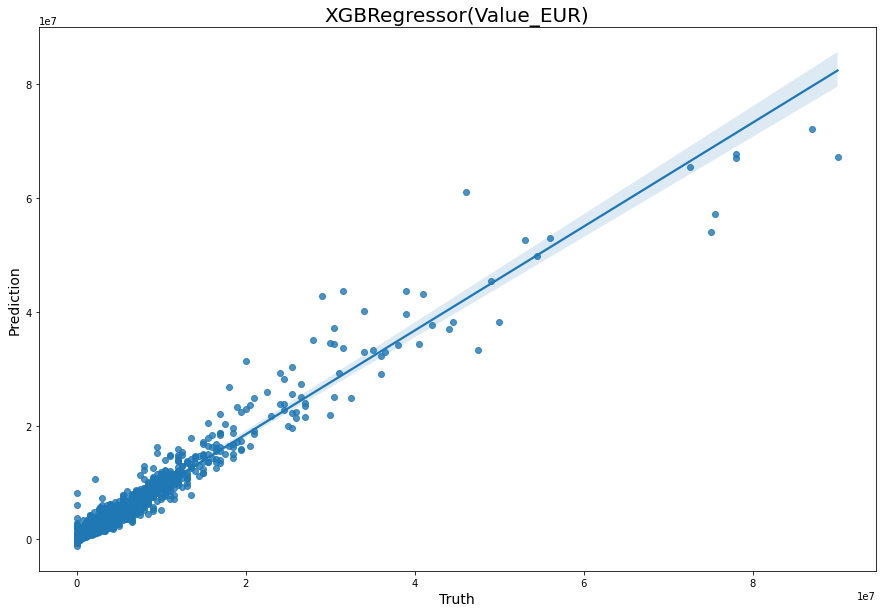

In [18]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
#                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean'),
                     MinMaxScaler()
                 )),
                 ('reg',  XGBRegressor(random_state=2, n_estmators=50))
],verbose=1)

pipe.fit(X_train_selected, y_train)
y_pred = pipe.predict(X_test_selected)

print(f'MSE : {mean_squared_error(y_test, y_pred)}')
print(f'MSE : {mean_squared_error(y_test, y_pred) ** 0.5}')
print('-------------')
print(f'테스트 세트 점수 : {r2_score(y_test, y_pred)}')

y_pred_train = pipe.predict(X_train_selected)
print(f'훈련 세트 점수 : {r2_score(y_train, y_pred_train)}')

fig = plt.figure(figsize=[15,10])
sns.regplot(x=y_test, 
           y=y_pred, 
           fit_reg=True);

plt.title("XGBRegressor(Value_EUR)", fontsize=20)
plt.xlabel('Truth', fontsize=14)

plt.ylabel('Prediction', fontsize=14)
plt.show()

In [19]:
X_test_selected

preferred_foot_Right  international_reputation  ...  potential  wage_eur
9643                      0                         1  ...         76      3000
13672                     1                         1  ...         62      3000
3691                      0                         1  ...         72      4000
275                       0                         1  ...         89     28000
12002                     1                         1  ...         76         0
...                     ...                       ...  ...        ...       ...
15211                     0                         1  ...         66       500
15240                     1                         1  ...         65       900
16189                     1                         1  ...         73      1000
13199                     0                         1  ...         72      2000
5805                      1                         1  ...         71      3000

[4736 rows x 47 columns]

In [20]:
dataset = pd.DataFrame(X_test_transformed.tolist())

In [21]:
 dataset.columns =test_features_transform

In [22]:
# from pdpbox.pdp import pdp_interact, pdp_interact_plot


enc = OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler()

reg = XGBRegressor(random_state=2, n_estimators=50)

X_train_transformed = enc.fit_transform(X_train)
X_test_transformed = enc.transform(X_test)
X_train_imputed = imp.fit_transform(X_train_transformed)
X_test_imputed = imp.transform(X_test_transformed)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)

[07:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### SHAP

In [23]:
!pip install shap

     |████████████████████████████████| 371 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509229 sha256=4a80eece937bd59f50a21a9d89d6c932ce7ed658544b3ab2c474ad1b508cb312
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [24]:
row = dataset.iloc[[250]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

preferred_foot_Right  preferred_foot_Left  ...  skill_moves  wage_eur
250                   1.0                  0.0  ...         0.25  0.001786

[1 rows x 107 columns]

In [25]:
import shap
explainer = shap.TreeExplainer(reg) 
shap.initjs() #인라인 자바스크립트

shap.force_plot(
    base_value=explainer.expected_value,  # 보통 평균값으로 잡는다.
    shap_values=explainer.shap_values(row), # Shap Value 계산
    features=row
)

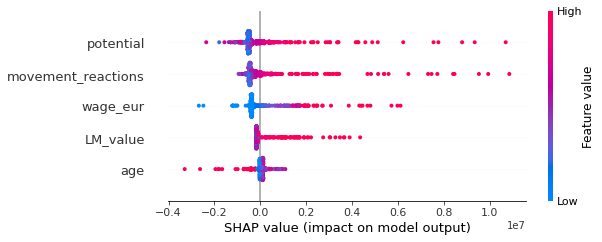

In [32]:
shap_values = explainer.shap_values(dataset.iloc[:500])
shap.summary_plot(shap_values, dataset.iloc[:500], max_display=5)

In [33]:
shap.summary_plot(shap_values, dataset.iloc[:500], plot_type="bar", max_display=6)